In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.mixture import GaussianMixture
#run kmeans and gaussian and interpret, keep how many clusters i need and change
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.special import entr
import plotly.express as px


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Gaukhar-ai/for_my_Thinkful_work/master/capstone/Stock%20Market_1B_predictions/stock_market_data.csv')
df.head()
#print(df['netmargin'])

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
0,ZYME,8269000.0,3.091,9007000.0,636578000.0,-3.765,-37487000.0,48686718.0,0.170,-35880000.0,...,-162932000.0,-2.154,3.091,-0.358217,-4.339097835,-0.823549,0.181661,-16.467038,6.807722,0.014149
1,ZYME,1877000.0,7.288,6881000.0,368205000.0,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-145437000.0,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
2,ZYME,7860000.0,3.146,6755000.0,400037000.0,-3.877,-10880000.0,43445379.0,0.181,-33564000.0,...,-63920000.0,0.004,3.146,-0.197080,-4.270229008,-0.277127,0.200204,6200.000000,6.678431,0.016886
3,ZYME,7882000.0,2.112,7829000.0,414547000.0,-3.689,-13317000.0,32837975.0,0.240,-29432000.0,...,-52196000.0,0.028,2.112,-0.191239,-3.734077645,-0.415356,0.245839,785.714286,8.874183,0.018886
4,ZYME,11925000.0,3.048,8065000.0,238279000.0,-1.144,-21302000.0,32020437.0,0.372,-14553000.0,...,-28993000.0,0.616,3.048,-0.130571,-1.220377358,-0.665162,0.372362,26.266234,6.440652,0.033847


In [3]:
df.shape #check the number of rows and cols

(40277, 31)

In [4]:
df.info() #checking the types of the data we have 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40277 entries, 0 to 40276
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ticker                   40277 non-null  object 
 1   revenue                  39949 non-null  float64
 2   pb                       38433 non-null  float64
 3   debt                     39416 non-null  float64
 4   assets                   39416 non-null  float64
 5   netmargin                38980 non-null  float64
 6   ncfo                     39683 non-null  float64
 7   shareswa                 40072 non-null  float64
 8   sps                      39800 non-null  float64
 9   opinc                    39949 non-null  float64
 10  assetsc                  30302 non-null  float64
 11  liabilitiesc             30265 non-null  float64
 12  price                    38513 non-null  float64
 13  calendardate             40277 non-null  object 
 14  datekey               

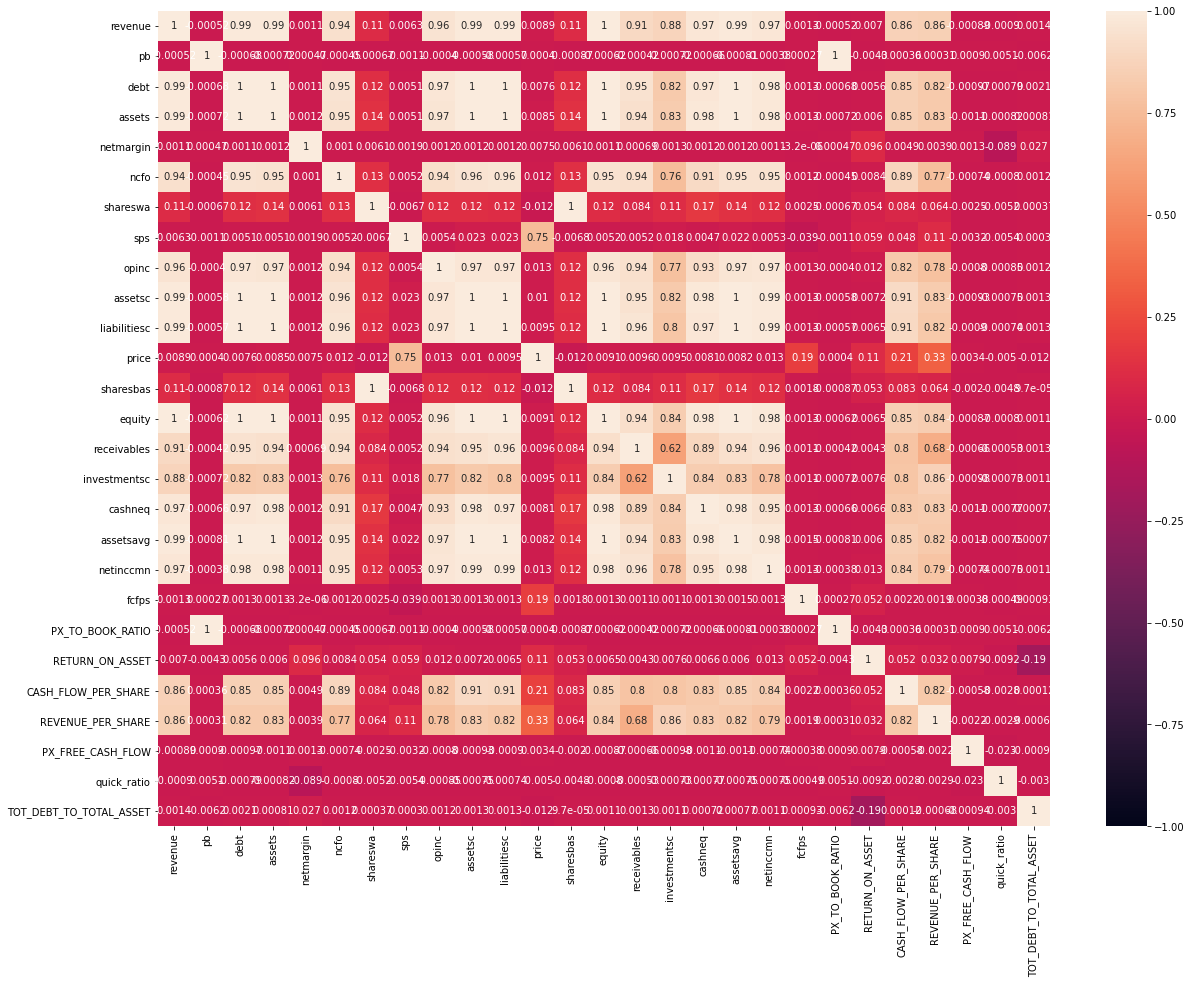

In [5]:
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [6]:
df['datekey'].nunique()
#i see that i have two types of dates above: datekey and calendardate. Checking how many rows of datekey I have

584

In [7]:
(df['datekey'] == df['calendardate']).mean() # 83% they match, I see that they're highly correlated, so I can drop one of them.


0.8301015467884897

In [8]:
df['calendardate'].unique() 
#deciding which quarter to pick. Futher I'll investigate clusters based on the chosen dates.

array(['3/31/2020', '12/31/2019', '9/30/2019', '6/30/2019', '3/31/2019',
       '12/31/2018', '9/30/2018', '6/30/2018', '3/31/2018', '12/31/2017',
       '9/30/2017', '6/30/2017', '3/31/2017', '12/31/2016', '12/31/2015',
       '9/30/2016', '6/30/2016', '3/31/2016', '9/30/2015', '6/30/2015',
       '3/31/2015', '6/30/2020'], dtype=object)

In [9]:
df['calendardate'] = pd.to_datetime(df['calendardate'])
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
0,ZYME,8269000.0,3.091,9007000.0,636578000.0,-3.765,-37487000.0,48686718.0,0.170,-35880000.0,...,-162932000.0,-2.154,3.091,-0.358217,-4.339097835,-0.823549,0.181661,-16.467038,6.807722,0.014149
1,ZYME,1877000.0,7.288,6881000.0,368205000.0,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-145437000.0,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
2,ZYME,7860000.0,3.146,6755000.0,400037000.0,-3.877,-10880000.0,43445379.0,0.181,-33564000.0,...,-63920000.0,0.004,3.146,-0.197080,-4.270229008,-0.277127,0.200204,6200.000000,6.678431,0.016886
3,ZYME,7882000.0,2.112,7829000.0,414547000.0,-3.689,-13317000.0,32837975.0,0.240,-29432000.0,...,-52196000.0,0.028,2.112,-0.191239,-3.734077645,-0.415356,0.245839,785.714286,8.874183,0.018886
4,ZYME,11925000.0,3.048,8065000.0,238279000.0,-1.144,-21302000.0,32020437.0,0.372,-14553000.0,...,-28993000.0,0.616,3.048,-0.130571,-1.220377358,-0.665162,0.372362,26.266234,6.440652,0.033847


In [10]:
#picked the dates 
df = df[df['calendardate'].between('2019-10-01', '2020-01-01')]
#df.head()
#print(df['netmargin'])

In [11]:
from scipy.stats.mstats import winsorize
import scipy.stats

In [12]:
#converting operating margin to a numerical data, apparently there's a bad data, which is giving it as an object.

df['OPER_MARGIN'] = pd.to_numeric(df['OPER_MARGIN'],errors='coerce') #errors = 'coerse' - converts to NA

In [13]:
q_low = df["netmargin"].quantile(0.05)

q_hi = df["netmargin"].quantile(0.98)


#X

#r

In [14]:
#q = df["netmargin"].quantile(0.80)
#df[df["netmargin"] < q]
q_low = df["OPER_MARGIN"].quantile(0.1)
q_hi  = df["OPER_MARGIN"].quantile(0.80)

df = df[(df["OPER_MARGIN"] < q_hi) & (df["OPER_MARGIN"] > q_low)]

#at this point I'm trying all the possible ways to see if netmargin values are going to change. My attempts don't end here
#you'll see my attempts below too

(array([ 32.,  35.,  31.,  87., 185., 315., 267., 190., 150.,  79.]),
 array([-0.18 , -0.134, -0.088, -0.042,  0.004,  0.05 ,  0.096,  0.142,
         0.188,  0.234,  0.28 ]),
 <BarContainer object of 10 artists>)

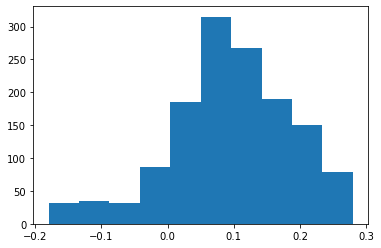

In [15]:

plt.hist(round(df['OPER_MARGIN'], 2), bins = 10)

In [16]:
from scipy import stats


stats.zscore(round(df['OPER_MARGIN'], 2))

array([-0.91993723, -0.37616128, -2.55126508, ..., -0.37616128,
       -1.46371318,  0.71139062])

In [17]:
#I'm checking if the data has the stocks I'm interested in. 
#So I realized looking at the output that it doesn't have all the stocks in the market. Also that stocks in the dataset 
#are more stable ones, so called 'long term growth stocks' but no penny stocks found.

df[df['ticker'].isin(['AMD', 'BA', 'GE', 'HTZ', 'AAL', 'NCLH', 'JILL', 'INTEQ', 'GLIBA', 'MRVL', 'NLOK'])] #can drop quick_ratio or drop HTZ, GE

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
15152,NLOK,6.180000e+08,1.855,4.592000e+09,1.854700e+10,4.604,3.990000e+08,6.210000e+08,0.995,6.200000e+07,...,3.690000e+09,2.113,1.855,0.223355,0.100324,0.640445,0.991967,12.224326,2.745385,0.247587
15741,NCLH,1.480618e+09,1.907,6.801693e+09,1.668460e+10,0.082,3.418510e+08,2.128776e+08,6.955,1.993760e+08,...,9.302280e+08,0.863,1.907,0.057823,0.134657,1.606763,6.959180,67.682503,0.091504,0.407663
16554,MRVL,7.176710e+08,1.858,1.439024e+09,1.113324e+10,2.470,5.583800e+07,6.572840e+08,1.092,-1.144950e+08,...,1.584391e+09,0.413,1.858,0.152838,-0.159537,0.083253,1.070033,58.208232,1.605188,0.129255
22792,HTZ,2.325000e+09,1.265,1.893700e+10,2.462700e+10,-0.051,6.670000e+08,1.170000e+08,19.872,8.900000e+07,...,-5.800000e+07,-13.034,1.265,-0.002307,0.038280,4.693162,16.359223,-1.208378,NaN,0.768953
25128,GE,1.573700e+10,3.442,9.088200e+10,2.660480e+11,0.034,6.739000e+09,8.733549e+09,1.802,2.186000e+09,...,-5.439000e+09,0.732,3.442,-0.018816,0.138908,0.771622,1.801902,15.245902,NaN,0.341600
36147,BA,1.791100e+10,-21.276,2.730200e+10,1.336250e+11,-0.056,-2.220000e+09,5.627912e+08,31.825,-2.599000e+09,...,-6.360000e+08,-7.011,-21.276,-0.004962,-0.145106,-3.944624,31.825300,-46.464128,0.253175,0.204318
38187,AMD,2.127000e+09,18.191,6.850000e+08,6.028000e+09,0.080,4.420000e+08,1.139000e+09,1.867,3.480000e+08,...,3.410000e+08,0.253,18.191,0.063995,0.163611,0.396901,1.909974,182.529644,1.425180,0.113636
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,6.000000e+08,4.380580e+08,25.825,7.290000e+08,...,1.686000e+09,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446


In [18]:
df = df.replace([np.inf, -np.inf], np.nan)
#replacing any irrelevant values to null values

In [19]:
df = df.dropna() #dropping the null values

In [20]:
df.info() #check for infinity how many rows where dropped

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1179 entries, 65 to 40257
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ticker                   1179 non-null   object        
 1   revenue                  1179 non-null   float64       
 2   pb                       1179 non-null   float64       
 3   debt                     1179 non-null   float64       
 4   assets                   1179 non-null   float64       
 5   netmargin                1179 non-null   float64       
 6   ncfo                     1179 non-null   float64       
 7   shareswa                 1179 non-null   float64       
 8   sps                      1179 non-null   float64       
 9   opinc                    1179 non-null   float64       
 10  assetsc                  1179 non-null   float64       
 11  liabilitiesc             1179 non-null   float64       
 12  price                    1179 no

In [21]:
#df['calendardate']
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,4.192500e+07,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735
86,ZM,1.882510e+08,25.289,6.479200e+07,1.289845e+09,0.076,36554000.0,276679009.0,0.680,10553000.0,...,2.175000e+07,0.487,25.289,0.019134,0.056058,0.132249,0.681077,156.673511,2.922532,0.050232
159,ZEN,2.298710e+08,18.769,5.887460e+08,1.514589e+09,-0.157,32211000.0,112517000.0,2.043,-32301000.0,...,-1.696530e+08,0.382,18.769,-0.117291,-0.140518,0.287149,2.049213,200.602094,1.277170,0.388717
180,ZBRA,1.192000e+09,7.490,1.377000e+09,4.711000e+09,0.142,265000000.0,53921478.0,22.106,188000000.0,...,5.440000e+08,11.572,7.490,0.116389,0.157718,4.914554,22.106219,22.073972,0.457977,0.292295
201,ZBH,2.125700e+09,2.485,8.221400e+09,2.463870e+10,0.151,423300000.0,206000000.0,10.319,336800000.0,...,1.131600e+09,4.218,2.485,0.046449,0.158442,2.058008,10.334767,35.486012,0.575854,0.333678


In [22]:
df.isna().sum() #no nulls 

ticker                     0
revenue                    0
pb                         0
debt                       0
assets                     0
netmargin                  0
ncfo                       0
shareswa                   0
sps                        0
opinc                      0
assetsc                    0
liabilitiesc               0
price                      0
calendardate               0
datekey                    0
sharesbas                  0
equity                     0
receivables                0
investmentsc               0
cashneq                    0
assetsavg                  0
netinccmn                  0
fcfps                      0
PX_TO_BOOK_RATIO           0
RETURN_ON_ASSET            0
OPER_MARGIN                0
CASH_FLOW_PER_SHARE        0
REVENUE_PER_SHARE          0
PX_FREE_CASH_FLOW          0
quick_ratio                0
TOT_DEBT_TO_TOTAL_ASSET    0
dtype: int64

In [23]:
df = df[~df['ticker'].isin(['AUPH', 'NK', 'ZYME', 'ZGNX', 'LBRDA', 'CRON', 'TM'])] #filtering rows, dont need ~ AUPH AND NK

In [24]:
#for checking the ticker when needed
df_original = df.copy()

In [25]:
keep_cols = ['TOT_DEBT_TO_TOTAL_ASSET', 'PX_FREE_CASH_FLOW', 'REVENUE_PER_SHARE', 'CASH_FLOW_PER_SHARE',
            'RETURN_ON_ASSET', 'PX_TO_BOOK_RATIO', 'quick_ratio', 'equity', 'netmargin']
df=df[keep_cols]
df.head()

#cleaned the data, these are the features I'll use for clustering stocks.

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,REVENUE_PER_SHARE,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,equity,netmargin
65,0.195735,7.010309,0.427586,0.099426,0.012826,2.931,1.933891,1.975430e+09,-0.009
86,0.050232,156.673511,0.681077,0.132249,0.019134,25.289,2.922532,8.339430e+08,0.076
159,0.388717,200.602094,2.049213,0.287149,-0.117291,18.769,1.277170,4.579840e+08,-0.157
180,0.292295,22.073972,22.106219,4.914554,0.116389,7.490,0.457977,1.839000e+09,0.142
201,0.333678,35.486012,10.334767,2.058008,0.046449,2.485,0.575854,1.238810e+10,0.151


In [26]:
df.corr() #check the correlation between features

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,REVENUE_PER_SHARE,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,equity,netmargin
TOT_DEBT_TO_TOTAL_ASSET,1.000000,-0.038769,-0.005817,-0.001146,-0.101658,-0.010939,-0.295404,-0.001929,-0.095813
PX_FREE_CASH_FLOW,-0.038769,1.000000,-0.009809,-0.016905,0.037050,0.013829,0.110680,-0.002815,0.003886
REVENUE_PER_SHARE,-0.005817,-0.009809,1.000000,0.861292,0.005888,-0.002925,-0.046998,0.769733,-0.018407
CASH_FLOW_PER_SHARE,-0.001146,-0.016905,0.861292,1.000000,0.075155,-0.004970,-0.067740,0.653637,0.017270
RETURN_ON_ASSET,-0.101658,0.037050,0.005888,0.075155,1.000000,0.005246,-0.049962,-0.002396,0.388514
PX_TO_BOOK_RATIO,-0.010939,0.013829,-0.002925,-0.004970,0.005246,1.000000,0.008617,-0.002343,-0.007326
quick_ratio,-0.295404,0.110680,-0.046998,-0.067740,-0.049962,0.008617,1.000000,-0.014047,0.047752
equity,-0.001929,-0.002815,0.769733,0.653637,-0.002396,-0.002343,-0.014047,1.000000,-0.000653
netmargin,-0.095813,0.003886,-0.018407,0.017270,0.388514,-0.007326,0.047752,-0.000653,1.000000


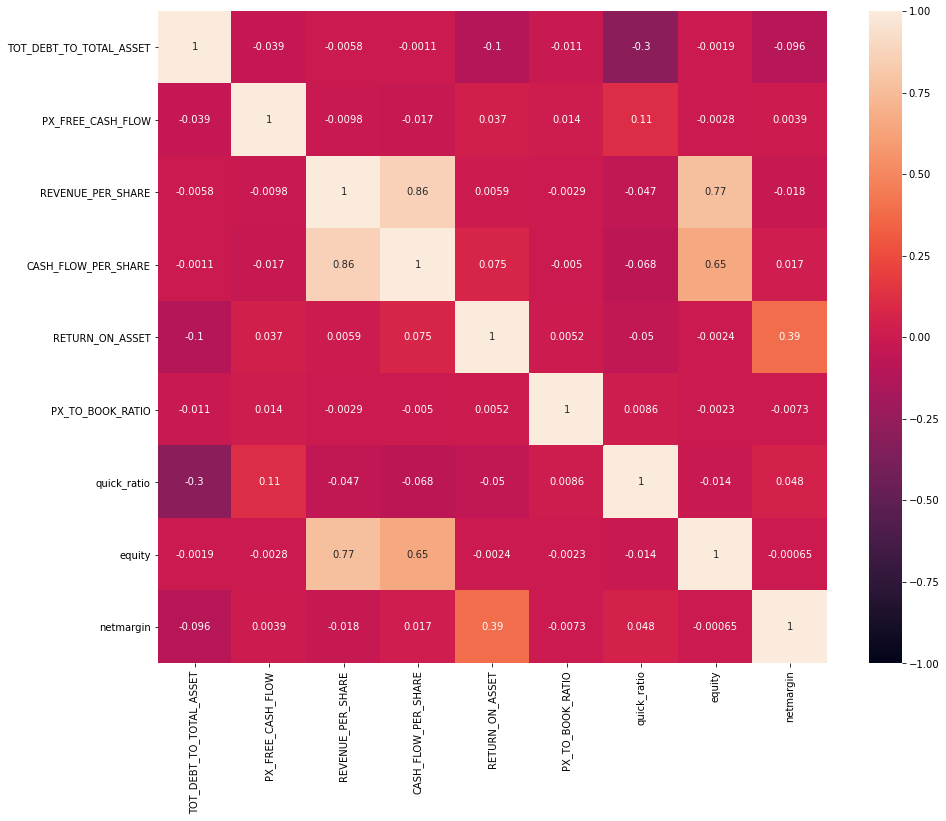

In [27]:
#let's use the visuals - the heatmap to see the correlation
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [28]:
#dropping the highly correlated columns 

drop_cols = ['equity', 'REVENUE_PER_SHARE']
df.drop(drop_cols, axis = 1, inplace=True)
df.head()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
65,0.195735,7.010309,0.099426,0.012826,2.931,1.933891,-0.009
86,0.050232,156.673511,0.132249,0.019134,25.289,2.922532,0.076
159,0.388717,200.602094,0.287149,-0.117291,18.769,1.277170,-0.157
180,0.292295,22.073972,4.914554,0.116389,7.490,0.457977,0.142
201,0.333678,35.486012,2.058008,0.046449,2.485,0.575854,0.151


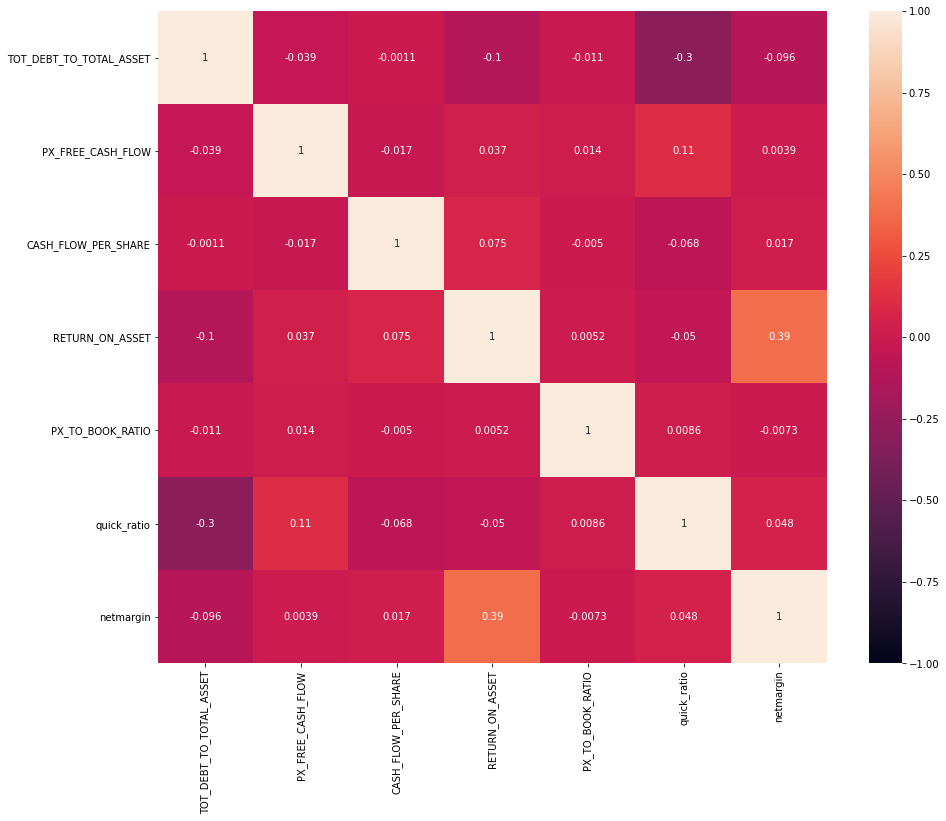

In [29]:
#now the data seems clean

plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [30]:
df.shape

(1178, 7)

In [31]:
#assigning X, y
X = df #clean data
y = df_original

In [32]:
y

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,4.192500e+07,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735
86,ZM,1.882510e+08,25.289,6.479200e+07,1.289845e+09,0.076,36554000.0,276679009.0,0.680,10553000.0,...,2.175000e+07,0.487,25.289,0.019134,0.056058,0.132249,0.681077,156.673511,2.922532,0.050232
159,ZEN,2.298710e+08,18.769,5.887460e+08,1.514589e+09,-0.157,32211000.0,112517000.0,2.043,-32301000.0,...,-1.696530e+08,0.382,18.769,-0.117291,-0.140518,0.287149,2.049213,200.602094,1.277170,0.388717
180,ZBRA,1.192000e+09,7.490,1.377000e+09,4.711000e+09,0.142,265000000.0,53921478.0,22.106,188000000.0,...,5.440000e+08,11.572,7.490,0.116389,0.157718,4.914554,22.106219,22.073972,0.457977,0.292295
201,ZBH,2.125700e+09,2.485,8.221400e+09,2.463870e+10,0.151,423300000.0,206000000.0,10.319,336800000.0,...,1.131600e+09,4.218,2.485,0.046449,0.158442,2.058008,10.334767,35.486012,0.575854,0.333678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40154,AAP,2.112614e+09,3.090,2.764479e+09,1.124852e+10,0.045,158363000.0,69423000.0,30.431,126139000.0,...,4.868960e+08,8.544,3.090,0.043565,0.059708,2.286520,30.502923,18.533474,0.247478,0.245764
40175,AAON,1.225740e+08,8.872,0.000000e+00,3.714240e+08,0.131,27342000.0,52060833.0,2.354,21430000.0,...,5.371100e+07,1.168,8.872,0.155083,0.174833,0.524823,2.352777,42.303082,1.995449,0.000000
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,600000000.0,438057971.0,25.825,729000000.0,...,1.686000e+09,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446
40238,AA,2.436000e+09,0.971,1.800000e+09,1.463100e+10,-0.124,262000000.0,185572917.0,13.127,-108000000.0,...,-1.125000e+09,1.654,0.971,-0.074250,-0.044335,1.411844,13.126915,13.004837,0.600468,0.123026


In [33]:
X

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
65,0.195735,7.010309,0.099426,0.012826,2.931,1.933891,-0.009
86,0.050232,156.673511,0.132249,0.019134,25.289,2.922532,0.076
159,0.388717,200.602094,0.287149,-0.117291,18.769,1.277170,-0.157
180,0.292295,22.073972,4.914554,0.116389,7.490,0.457977,0.142
201,0.333678,35.486012,2.058008,0.046449,2.485,0.575854,0.151
...,...,...,...,...,...,...,...
40154,0.245764,18.533474,2.286520,0.043565,3.090,0.247478,0.045
40175,0.000000,42.303082,0.524823,0.155083,8.872,1.995449,0.131
40217,0.557446,-31.481888,1.369682,0.027648,-106.470,0.313145,0.037
40238,0.123026,13.004837,1.411844,-0.074250,0.971,0.600468,-0.124


In [34]:
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist

In [35]:
#!pip install yellowbrick
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(df)



In [36]:
#scaling the data to make them all equal on one scale.
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(scaled, columns=df.columns, index = df.index)
df_scaled.head()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
65,-0.683492,-0.060678,-0.390175,-0.398072,-0.032159,0.319745,-0.392442
86,-1.398403,0.355960,-0.383500,-0.318866,0.331491,0.953047,0.021462
159,0.264702,0.478250,-0.351998,-2.031868,0.225444,-0.100936,-1.113123
180,-0.209057,-0.018743,0.589083,0.902300,0.041992,-0.625693,0.342847
201,-0.005722,0.018594,0.008144,0.024113,-0.039413,-0.550184,0.386672


----------------------------------------------------------------------------------------------------


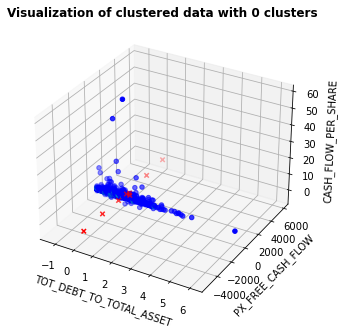

----------------------------------------------------------------------------------------------------


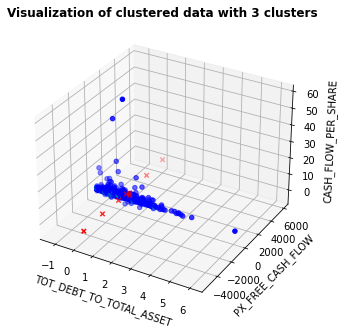

In [37]:

clusters = [0,3]

for cluster in clusters:
    
    print('-'*100)
    
    kmeans = KMeans(n_clusters= 8, random_state=55).fit(X)
    
    # define the cluster centers
    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 0]
    C2 = cluster_centers[:, 1]
    C3 = cluster_centers[:, 2]


    # create a new plot
    fig = plt.figure()
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = X_train_robust[:,0]
    y = X_train_robust[:,1]
    z = X_train_robust[:,2]

    # define the axes labels
    column_names = df.columns
    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])

    # create a new plot
    ax.scatter(x, y, z, c = kmeans.labels_.astype(float), cmap='winter')
    ax.scatter(C1, C2, C3, marker="x", color='r')

    plt.title('Visualization of clustered data with {} clusters'.format(cluster), fontweight='bold')

    plt.show()

In [38]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics

In [39]:
#getting the elbow plot to see what might be the right number of clusters

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,20)

for k in K: #Building and fitting the model kmeanModel = KMeans(n_clusters=k).fit(X) kmeanModel.fit(X)
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                  'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
             'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_

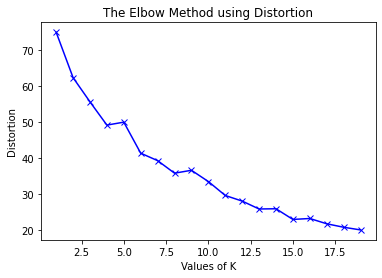

In [40]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

#can see the drastic change between 7.5 and 10

In [112]:
kmeans = KMeans(n_clusters = 8, random_state=55)
kmeans.fit(X)
y_pred = kmeans.predict(X)
print(y_pred)

[0 0 0 ... 0 0 0]


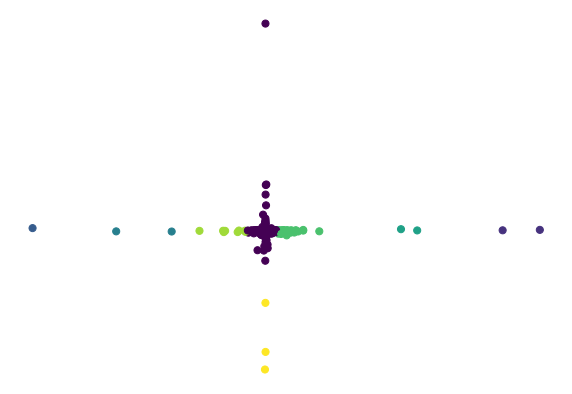

In [113]:
pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(10,7))
colours = 'rbgymrck'
plt.scatter(pca[:, 0], pca[:, 1], c=y_pred, s=50, cmap='viridis')
#for i in range(pca.shape[0]):
    #plt.text(pca[i,0], pca[i, 1], str(y_pred[i]),

             #color=colours[y_pred[i]],
             #fontdict={'weight': 'bold', 'size': 10}
        #)

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

#

pca = PCA(n_components=7).fit_transform(X)
y_pred = KMeans(n_clusters=8, random_state=55).fit_predict(X)

X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X,
    pca,
    test_size=0.2,
    random_state=55)


In [114]:
pd.Series(kmeans.labels_).value_counts() #check 1, 2,4, 5, 3 for outliers in net margin
#tried the clusters from 7 to 11 and chose 8

0    1138
5      22
6       8
7       3
4       2
3       2
1       2
2       1
dtype: int64

In [44]:
df['label'] = kmeans.labels_ #0-4(changable) above clusters #adding a label to a df
df['label'] = df['label'].astype(str)

In [45]:
centroids = df.groupby(['label']).mean() #grouping by label, shows avg 
    #shows the highest 

In [46]:
centroids.style.background_gradient() 

#on this table we see the average value for each cluster

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
label,,,,,,,
0,0.337234,17.680807,2.069721,0.046001,2.779516,1.418272,0.073571
1,0.050844,5871.484019,0.258723,-0.035342,14.746000,6.220106,0.005000
2,0.214989,-5302.000000,0.186488,-0.307089,-26.157000,0.266408,-0.045000
3,0.160022,-2755.625000,0.148124,-0.012584,3.091000,0.874266,-0.021500
4,0.149101,3307.111111,0.323432,-0.046888,6.547500,1.788574,0.016500
5,0.288207,570.602165,0.347849,0.005520,10.575591,1.729500,0.008636
6,0.230035,-792.144767,0.862305,0.010654,6.268500,2.268207,0.029250
7,0.519079,17.903664,1.873236,0.132097,771.125000,0.634315,0.077667


In [47]:
#df_original[df['label'] == '5']

In [103]:
from sklearn import preprocessing

In [104]:
df['label'] = kmeans.labels_ 
#df['label'] = df['label'].astype(str)

#normalizing the data for a better and easier understanding of the differences between clusters
#MinMax scaler puts from 0-1

df = df.apply(lambda x: (x-x.min(axis=0))/(x.max(axis=0) - x.min(axis=0))) 
df['label'] = kmeans.labels_

In [105]:
#a = np.array(df['netmargin']) #winsorizing the netmargin, cuz it's very high in value, almost all the data is 0.99

centroids = df.groupby(['label']).mean() #grouping by label, shows avg number for a cluster
centroids.style.background_gradient()

In [53]:
#print(df['netmargin'])

centroids = df.groupby(['label']).mean() #grouping by label, shows avg number for a cluster
centroids.style.background_gradient()

In [55]:
#df_original[df_original['netmargin']>2] #looking for outliers in netmargin, took out some of them and dropped them in the
#beginning, before the clustering.
#What I noticed is that the more outliers - companies I dropped the higher the netmargin numbers become. So my assumption is 
#that these tickers are stable, growth companies, that's why the netmargin might be good in comparison with other variables.
#I started to check for outliers from 10 (in the code above), but found outliers from # 7 and went down to 2, removed these tickers too from the clusters.
#They're in a special outliers classification and need futher investigation. 

pd.Series(kmeans.labels_).value_counts() 

In [57]:
df_original[df['label'] == 2] #checking what i have in label 1

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
32919,CHWY,1.354525e+09,-26.157,200439000.0,932321000.0,-0.045,74334000.0,401319000.0,3.375,-60597000.0,...,-252370000.0,-0.005,-26.157,-0.307089,-0.044737,0.186488,3.398206,-5302.0,0.266408,0.214989


In [58]:
df_original[df['label'] == 0] #the largest cluster, looking at the similarities in values among variables. 

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,4.192500e+07,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735
86,ZM,1.882510e+08,25.289,6.479200e+07,1.289845e+09,0.076,36554000.0,276679009.0,0.680,10553000.0,...,2.175000e+07,0.487,25.289,0.019134,0.056058,0.132249,0.681077,156.673511,2.922532,0.050232
159,ZEN,2.298710e+08,18.769,5.887460e+08,1.514589e+09,-0.157,32211000.0,112517000.0,2.043,-32301000.0,...,-1.696530e+08,0.382,18.769,-0.117291,-0.140518,0.287149,2.049213,200.602094,1.277170,0.388717
180,ZBRA,1.192000e+09,7.490,1.377000e+09,4.711000e+09,0.142,265000000.0,53921478.0,22.106,188000000.0,...,5.440000e+08,11.572,7.490,0.116389,0.157718,4.914554,22.106219,22.073972,0.457977,0.292295
201,ZBH,2.125700e+09,2.485,8.221400e+09,2.463870e+10,0.151,423300000.0,206000000.0,10.319,336800000.0,...,1.131600e+09,4.218,2.485,0.046449,0.158442,2.058008,10.334767,35.486012,0.575854,0.333678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40154,AAP,2.112614e+09,3.090,2.764479e+09,1.124852e+10,0.045,158363000.0,69423000.0,30.431,126139000.0,...,4.868960e+08,8.544,3.090,0.043565,0.059708,2.286520,30.502923,18.533474,0.247478,0.245764
40175,AAON,1.225740e+08,8.872,0.000000e+00,3.714240e+08,0.131,27342000.0,52060833.0,2.354,21430000.0,...,5.371100e+07,1.168,8.872,0.155083,0.174833,0.524823,2.352777,42.303082,1.995449,0.000000
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,600000000.0,438057971.0,25.825,729000000.0,...,1.686000e+09,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446
40238,AA,2.436000e+09,0.971,1.800000e+09,1.463100e+10,-0.124,262000000.0,185572917.0,13.127,-108000000.0,...,-1.125000e+09,1.654,0.971,-0.074250,-0.044335,1.411844,13.126915,13.004837,0.600468,0.123026


sns.scatterplot(x=pca[:, 0], y = pca[:, 1], hue = df['label'])
plt.figure(figsize = (10,5))
colors = 'rbgymrck'


plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

pd.Series(kmeans.labels_).value_counts() 

In [61]:
df[df['label'] == 2] #filtered to row number 1 (cluster) #6 revenue per share is high 9-quick ratio, price for 
#cash flow is high too. #cash flow, quick ratio is okay, #10 is negative but not much debt, all therapies

#netmargin, oper margin 

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
32919,0.11488,0.0,0.059151,0.328302,0.585859,0.010333,0.136034,2


In [62]:
df_original[df['label'] == 3] #normalized data easy to compare among clusters

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
23542,HL,224945000.0,0.993,533770000.0,2.637308e+09,-0.036,57257000.0,502902000.0,0.447,7605000.0,...,-100109000.0,-0.001,0.993,-0.037509,0.033808,0.115545,0.453939,-3390.00,0.690966,0.202392
33576,CDAY,221800000.0,5.189,716000000.0,6.085700e+09,-0.007,26000000.0,144088431.0,1.539,19700000.0,...,78700000.0,-0.032,5.189,0.012340,0.088819,0.180704,1.541547,-2121.25,1.057567,0.117653


In [63]:
df[df['label'] == 1] 

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
7953,0.023231,0.926684,0.061459,0.566950,0.603135,0.359644,0.144769,1
30098,0.031105,1.000000,0.058068,0.581239,0.602750,0.195651,0.145884,1


In [64]:
df[df['label'] == 5] #filtering, df['label'] gives true and falses

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
1666,0.194695,0.486682,0.071146,0.636009,0.597985,0.015498,0.167627,5
3943,0.261357,0.518958,0.063443,0.650323,0.597986,0.018485,0.162609,5
4048,0.058558,0.508025,0.052292,0.677763,0.604778,0.066965,0.188255,5
9062,0.197067,0.502677,0.060853,0.624863,0.598012,0.027207,0.160937,5
9627,0.153005,0.515997,0.056946,0.562848,0.604712,0.074121,0.125813,5
12458,0.066039,0.565235,0.058727,0.678092,0.601714,0.143989,0.156848,5
14411,0.182294,0.500890,0.058165,0.590672,0.612777,0.214902,0.152388,5
15508,0.226204,0.486939,0.055571,0.544211,0.601103,0.126305,0.111318,5
15600,0.100072,0.533541,0.057841,0.616989,0.599297,0.186147,0.155361,5
19758,0.154358,0.500895,0.057489,0.615670,0.598157,0.105765,0.147370,5


In [65]:
df[df['label'] == 7]  #profitable and cheap but have higher debt

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
8673,0.427466,0.457941,0.062114,0.710941,1.000000,0.010598,0.154432,7
14707,0.125740,0.459115,0.091100,0.706958,0.949160,0.045756,0.147928,7
32772,0.278904,0.458939,0.067171,0.758729,0.807394,0.024201,0.174131,7


In [66]:
df[df['label'] == 4] #cheaper than 7, no cash flow, profitable = oper margin, not diff with 7 but cheap, good for investments

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
17015,0.159257,0.72629,0.061704,0.608901,0.597541,0.050202,0.141424,4
33519,0.000088,0.75821,0.058921,0.518402,0.601495,0.107151,0.153503,4


In [67]:
df[df['label'] == 6] #cost is higher = px free cash flow, 

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
5648,0.058410,0.419570,0.057608,0.680829,0.601549,0.189066,0.158335,6
17724,0.164033,0.329046,0.071930,0.646137,0.597657,0.045169,0.157220,6
18736,0.111820,0.379605,0.064864,0.603818,0.598252,0.064432,0.126742,6
18925,0.143361,0.418614,0.058781,0.622623,0.598273,0.104384,0.158521,6
22325,0.000000,0.375642,0.077623,0.661730,0.597957,0.087794,0.156476,6
27503,0.274600,0.376981,0.057936,0.518875,0.601785,0.159633,0.101654,6
30317,0.195046,0.406836,0.072979,0.618132,0.597674,0.011070,0.186211,6
37968,0.036083,0.404308,0.057357,0.573438,0.602067,0.140145,0.153503,6


In [68]:
df[df['label'] == 0] 

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
65,0.104591,0.457726,0.058412,0.617663,0.598008,0.085201,0.142724,0
86,0.026842,0.470629,0.058691,0.623368,0.607346,0.129590,0.158521,0
159,0.207711,0.474417,0.060005,0.499973,0.604623,0.055715,0.115220,0
180,0.156188,0.459025,0.099266,0.711334,0.599912,0.018934,0.170786,0
201,0.178301,0.460181,0.075030,0.648074,0.597821,0.024227,0.172459,0
...,...,...,...,...,...,...,...,...
40154,0.131324,0.458719,0.076968,0.645466,0.598074,0.009483,0.152760,0
40175,0.000000,0.460769,0.062021,0.746333,0.600489,0.087965,0.168742,0
40217,0.297872,0.454407,0.069189,0.631069,0.552315,0.012431,0.151273,0
40238,0.065739,0.458243,0.069547,0.538903,0.597189,0.025332,0.121353,0


----------------------------------------------------------------------------------------------------


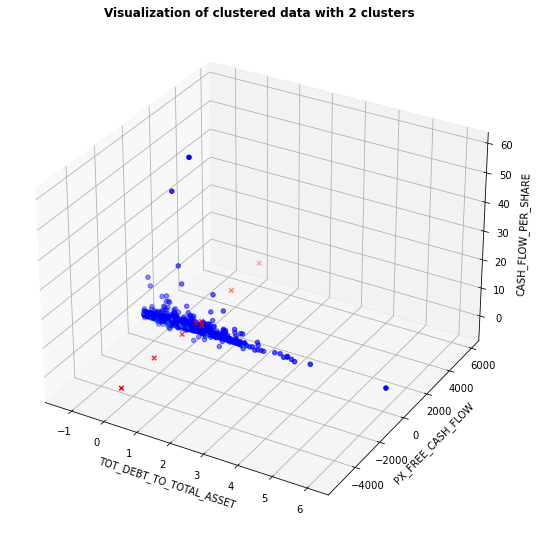

----------------------------------------------------------------------------------------------------


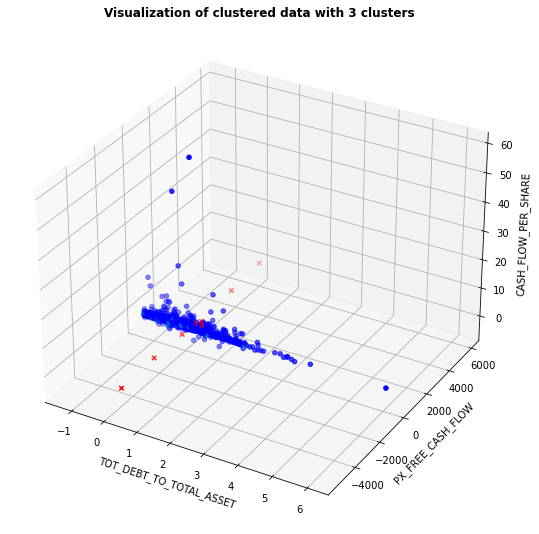

In [69]:
#Let's get to the fun part, visualizing our clusters! This will involve, in the non-PCA case, creating another 3D scatter plot,
#but in this instance,
#we will define the c parameter of our scatter to equal our model labels. This will correctly create the clusters for us.

clusters = [2,3]

for cluster in clusters:
    
    print('-'*100)
    
    kmeans = KMeans(n_clusters= 8, random_state=55).fit(X)
    
    # define the cluster centers
    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 0]
    C2 = cluster_centers[:, 1]
    C3 = cluster_centers[:, 2]


    # create a new plot
    fig = plt.figure(figsize = (9, 7))
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = X_train_robust[:,0]
    y = X_train_robust[:,1]
    z = X_train_robust[:,2]

    # define the axes labels
    column_names = df.columns
    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])

    # create a new plot
    ax.scatter(x, y, z, c = kmeans.labels_.astype(float), cmap='winter')
    ax.scatter(C1, C2, C3, marker="x", color='r')

    plt.title('Visualization of clustered data with {} clusters'.format(cluster), fontweight='bold')

    plt.show()

In [70]:
#let's see the other method of clustering: GaussianMixture, all the steps that i did above can be applied here too.

gauss = GaussianMixture(n_components=8, random_state=55)
gauss.fit(X)

GaussianMixture(n_components=8, random_state=55)

In [71]:
gauss.means_

array([[ 3.37233784e-01,  1.76808075e+01,  2.06972121e+00,
         4.60005067e-02,  2.77951582e+00,  1.41827220e+00,
         7.35711775e-02,  0.00000000e+00],
       [ 5.08435595e-02,  5.87148402e+03,  2.58722870e-01,
        -3.53421060e-02,  1.47460000e+01,  6.22010643e+00,
         5.00000000e-03,  1.00000000e+00],
       [ 2.14989258e-01, -5.30200000e+03,  1.86487707e-01,
        -3.07089045e-01, -2.61570000e+01,  2.66407884e-01,
        -4.50000000e-02,  2.00000000e+00],
       [ 1.60022421e-01, -2.75562500e+03,  1.48124457e-01,
        -1.25843150e-02,  3.09100000e+00,  8.74266456e-01,
        -2.15000000e-02,  3.00000000e+00],
       [ 1.49101350e-01,  3.30711111e+03,  3.23432113e-01,
        -4.68881770e-02,  6.54750000e+00,  1.78857384e+00,
         1.65000000e-02,  4.00000000e+00],
       [ 2.88207056e-01,  5.70602165e+02,  3.47848574e-01,
         5.52037623e-03,  1.05755909e+01,  1.72949989e+00,
         8.63636364e-03,  5.00000000e+00],
       [ 2.30034630e-01, -7.921447

In [72]:
prob_df = pd.DataFrame(gauss.predict_proba(X))
prob_df.shape

(1178, 8)

In [73]:
centroids = df.groupby(['label']).mean()

In [74]:
centroids.style.background_gradient() 

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
label,,,,,,,
0,0.180201,0.458646,0.075129,0.647669,0.597944,0.062050,0.158069
1,0.027168,0.963342,0.059764,0.574095,0.602942,0.277648,0.145326
2,0.114880,0.000000,0.059151,0.328302,0.585859,0.010333,0.136034
3,0.085508,0.219540,0.058825,0.594679,0.598075,0.037625,0.140401
4,0.079672,0.742250,0.060313,0.563652,0.599518,0.078677,0.147463
5,0.154004,0.506317,0.060520,0.611055,0.601201,0.076024,0.146002
6,0.122919,0.388825,0.064885,0.615698,0.599402,0.100212,0.149833
7,0.277370,0.458665,0.073462,0.725543,0.918851,0.026852,0.158830


In [75]:
df = df.apply(lambda x: (x-x.min(axis=0))/(x.max(axis=0) - x.min(axis=0)))

In [76]:
gauss = GaussianMixture(n_components=8, random_state=55)
gauss.fit(X)

GaussianMixture(n_components=8, random_state=55)

In [77]:
y_pred = gauss.predict(X)
print(y_pred)

[0 0 0 ... 0 0 0]


In [78]:
#df['label'] = gauss.l

In [102]:
gauss.predict(X).value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [80]:
#df['label'] = 
#gauss.predict(X)

In [81]:
#df['label'].value_counts()

In [82]:
#df['label'] = 
#pd.Series(gauss.predict(X)).value_counts() 


In [83]:
centroids = df.groupby(['label']).mean()

In [84]:
centroids.style.background_gradient() 

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin
label,,,,,,,
0.0,0.180201,0.458646,0.075129,0.647669,0.597944,0.062050,0.158069
0.14285714285714285,0.027168,0.963342,0.059764,0.574095,0.602942,0.277648,0.145326
0.2857142857142857,0.114880,0.000000,0.059151,0.328302,0.585859,0.010333,0.136034
0.42857142857142855,0.085508,0.219540,0.058825,0.594679,0.598075,0.037625,0.140401
0.5714285714285714,0.079672,0.742250,0.060313,0.563652,0.599518,0.078677,0.147463
0.7142857142857143,0.154004,0.506317,0.060520,0.611055,0.601201,0.076024,0.146002
0.8571428571428571,0.122919,0.388825,0.064885,0.615698,0.599402,0.100212,0.149833
1.0,0.277370,0.458665,0.073462,0.725543,0.918851,0.026852,0.158830


In [85]:
scipy.stats.entropy([0.731826, 0.267606, 5.687710e-04])


0.5855042262910504

In [86]:
prob_df['entropy'] = prob_df.apply(scipy.stats.entropy, axis=1)

In [87]:
prob_df.sort_values('entropy')

,0,1,2,3,4,5,6,7,entropy
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
788,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
787,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
786,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
785,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
390,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
389,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
df_original #have to add a new column 'label' to be able to see it on the plot in the original DF

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,4.192500e+07,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735
86,ZM,1.882510e+08,25.289,6.479200e+07,1.289845e+09,0.076,36554000.0,276679009.0,0.680,10553000.0,...,2.175000e+07,0.487,25.289,0.019134,0.056058,0.132249,0.681077,156.673511,2.922532,0.050232
159,ZEN,2.298710e+08,18.769,5.887460e+08,1.514589e+09,-0.157,32211000.0,112517000.0,2.043,-32301000.0,...,-1.696530e+08,0.382,18.769,-0.117291,-0.140518,0.287149,2.049213,200.602094,1.277170,0.388717
180,ZBRA,1.192000e+09,7.490,1.377000e+09,4.711000e+09,0.142,265000000.0,53921478.0,22.106,188000000.0,...,5.440000e+08,11.572,7.490,0.116389,0.157718,4.914554,22.106219,22.073972,0.457977,0.292295
201,ZBH,2.125700e+09,2.485,8.221400e+09,2.463870e+10,0.151,423300000.0,206000000.0,10.319,336800000.0,...,1.131600e+09,4.218,2.485,0.046449,0.158442,2.058008,10.334767,35.486012,0.575854,0.333678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40154,AAP,2.112614e+09,3.090,2.764479e+09,1.124852e+10,0.045,158363000.0,69423000.0,30.431,126139000.0,...,4.868960e+08,8.544,3.090,0.043565,0.059708,2.286520,30.502923,18.533474,0.247478,0.245764
40175,AAON,1.225740e+08,8.872,0.000000e+00,3.714240e+08,0.131,27342000.0,52060833.0,2.354,21430000.0,...,5.371100e+07,1.168,8.872,0.155083,0.174833,0.524823,2.352777,42.303082,1.995449,0.000000
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,600000000.0,438057971.0,25.825,729000000.0,...,1.686000e+09,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446
40238,AA,2.436000e+09,0.971,1.800000e+09,1.463100e+10,-0.124,262000000.0,185572917.0,13.127,-108000000.0,...,-1.125000e+09,1.654,0.971,-0.074250,-0.044335,1.411844,13.126915,13.004837,0.600468,0.123026


In [89]:
df_original['label'] = kmeans.labels_ #adding a new column 'label' to the original df

Started with raw metrics, correlated features dropped and left ratios(which is normalizing the data). 
We care about finance, cash, debt, profitability. Feature engineering with a threshold. 
For silhouette score tried euclidean, spherical 

In [90]:
from ipywidgets import interact

In [115]:
px.scatter(data_frame=df_original, x='RETURN_ON_ASSET', y='quick_ratio', color = 'label', hover_data=['ticker', 'netmargin', 'PX_FREE_CASH_FLOW'])

In [92]:
df_original #see the label col in the end:)

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET,label
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,...,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735,0
86,ZM,1.882510e+08,25.289,6.479200e+07,1.289845e+09,0.076,36554000.0,276679009.0,0.680,10553000.0,...,0.487,25.289,0.019134,0.056058,0.132249,0.681077,156.673511,2.922532,0.050232,0
159,ZEN,2.298710e+08,18.769,5.887460e+08,1.514589e+09,-0.157,32211000.0,112517000.0,2.043,-32301000.0,...,0.382,18.769,-0.117291,-0.140518,0.287149,2.049213,200.602094,1.277170,0.388717,0
180,ZBRA,1.192000e+09,7.490,1.377000e+09,4.711000e+09,0.142,265000000.0,53921478.0,22.106,188000000.0,...,11.572,7.490,0.116389,0.157718,4.914554,22.106219,22.073972,0.457977,0.292295,0
201,ZBH,2.125700e+09,2.485,8.221400e+09,2.463870e+10,0.151,423300000.0,206000000.0,10.319,336800000.0,...,4.218,2.485,0.046449,0.158442,2.058008,10.334767,35.486012,0.575854,0.333678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40154,AAP,2.112614e+09,3.090,2.764479e+09,1.124852e+10,0.045,158363000.0,69423000.0,30.431,126139000.0,...,8.544,3.090,0.043565,0.059708,2.286520,30.502923,18.533474,0.247478,0.245764,0
40175,AAON,1.225740e+08,8.872,0.000000e+00,3.714240e+08,0.131,27342000.0,52060833.0,2.354,21430000.0,...,1.168,8.872,0.155083,0.174833,0.524823,2.352777,42.303082,1.995449,0.000000,0
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,600000000.0,438057971.0,25.825,729000000.0,...,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446,0
40238,AA,2.436000e+09,0.971,1.800000e+09,1.463100e+10,-0.124,262000000.0,185572917.0,13.127,-108000000.0,...,1.654,0.971,-0.074250,-0.044335,1.411844,13.126915,13.004837,0.600468,0.123026,0


In [93]:
@interact
def plotting(x=df_original.columns, y = df_original.columns):
    fig = px.scatter(data_frame=df_original, x= x, y= y, color = 'label', hover_data=['ticker', 'PX_TO_BOOK_RATIO', 'CASH_FLOW_PER_SHARE'])
    fig.show()

interactive(children=(Dropdown(description='x', options=('ticker', 'revenue', 'pb', 'debt', 'assets', 'netmarg…


TOT_DEBT_TO_TOTAL_ASSET = The debt to total assets ratio is an indicator of a company's financial leverage. It tells you the percentage of a company's total assets that were financed by creditors. ... Debt is the total amount of all liabilities (current liabilities and long-term liabilities).

PX_TO_BOOK_RATIO = Measures the ratio between [MarketCap] and [EquityUSD]. 

RETURN_ON_ASSET = ROA, Return on equity measures a corporation's profitability by calculating the amount of [NetIncCmn] returned as a percentage of [EquityAvg].

OPER_MARGIN = Operating margin is a profitability ratio that shows how much profit a company makes from its core operations in relation to the total revenues it brings in. 

CASH_FLOW_PER_SHARE = Free Cash Flow per Share is a valuation metric calculated by dividing [FCF] by [SharesWA] and [ShareFactor].

PX_FREE_CASH_FLOW = The price-to-cash flow (P/CF) ratio is a stock valuation indicator or multiple that measures the value of a stock’s price relative to its operating cash flow per share. The ratio uses operating cash flow which adds back non-cash expenses such as depreciation and amortization to net income. It is especially useful for valuing stocks that have positive cash flow but are not profitable because of large non-cash charges.

QUICK RATIO = Quick Ratio = an indicator of a company's short-term liquidity position and measures a company's ability to meet its short-term obligations with its most liquid assets

NETMARGIN = Measures the ratio between a company's [NetIncCmn] and [Revenue].

LABEL 1 has a pretty high price per cash flow value, meaning that the stock price is high for these companies and the companies 
are very profitable. Let's see which stocks these are.

And here you're, two companies which went parabollic in just a year: Shopify(from $100 to $1106 per share) and newly created IPO Datadog(from $30 to $118)

Revenues are high. (Revenue = any activities that constitute an earning process). 

Assets are very high too, in billions, which is very rare among companies.
Very little debt.

The quick ratio is high too, which is very important.

Operating margin is slightly negative. (Operating margin is a profitability ratio that shows how much profit a company makes from its core operations in relation to the total revenues it brings in. Earnings before interest and taxes (EBIT) is the same metric as operating income and can be used in calculating operating margin)

In [94]:
df[df['label'] == 4] #lets see the cleaned data and compare values.

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label


In [95]:
df[df['label']==1] 

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
8673,0.427466,0.457941,0.062114,0.710941,1.000000,0.010598,0.154432,1.0
14707,0.125740,0.459115,0.091100,0.706958,0.949160,0.045756,0.147928,1.0
32772,0.278904,0.458939,0.067171,0.758729,0.807394,0.024201,0.174131,1.0


Lets see the label 3, the PX_FREE_CASH_FLOW is very low on the pairplot. 
Wow, indeed, very big negative numbers, different from other clusters.
This cluster is interesting, the price range differs from $70 to $300 and the lowest price of $5 among them is BB, worth to look into it later on. Very big gap. 

In [96]:
df_original[df['label']==3] 

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET,label


uff, I see PX_TO_BOOK_RATIO (pb = price to book ratio, measures the ration between MarketCap and Revenue) is super low at CHWY - this might be an outlier here - spotted! No price per cash flow either. 
HL = $ 5
CHWY = $ 66 

In [97]:
df_original[df['label']==2] 

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET,label


Cluster 6 seems like a week, negative cluster, let's check the price to book ratio, it's in the tail among other clusters on PX PX_TO_BOOK_RATIO and on PX_FREE_CASH_FLOW

In [98]:
df_original[df['label']=='6'] 

c:\users\gaukharjavarova\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET,label


<Figure size 648x504 with 0 Axes>

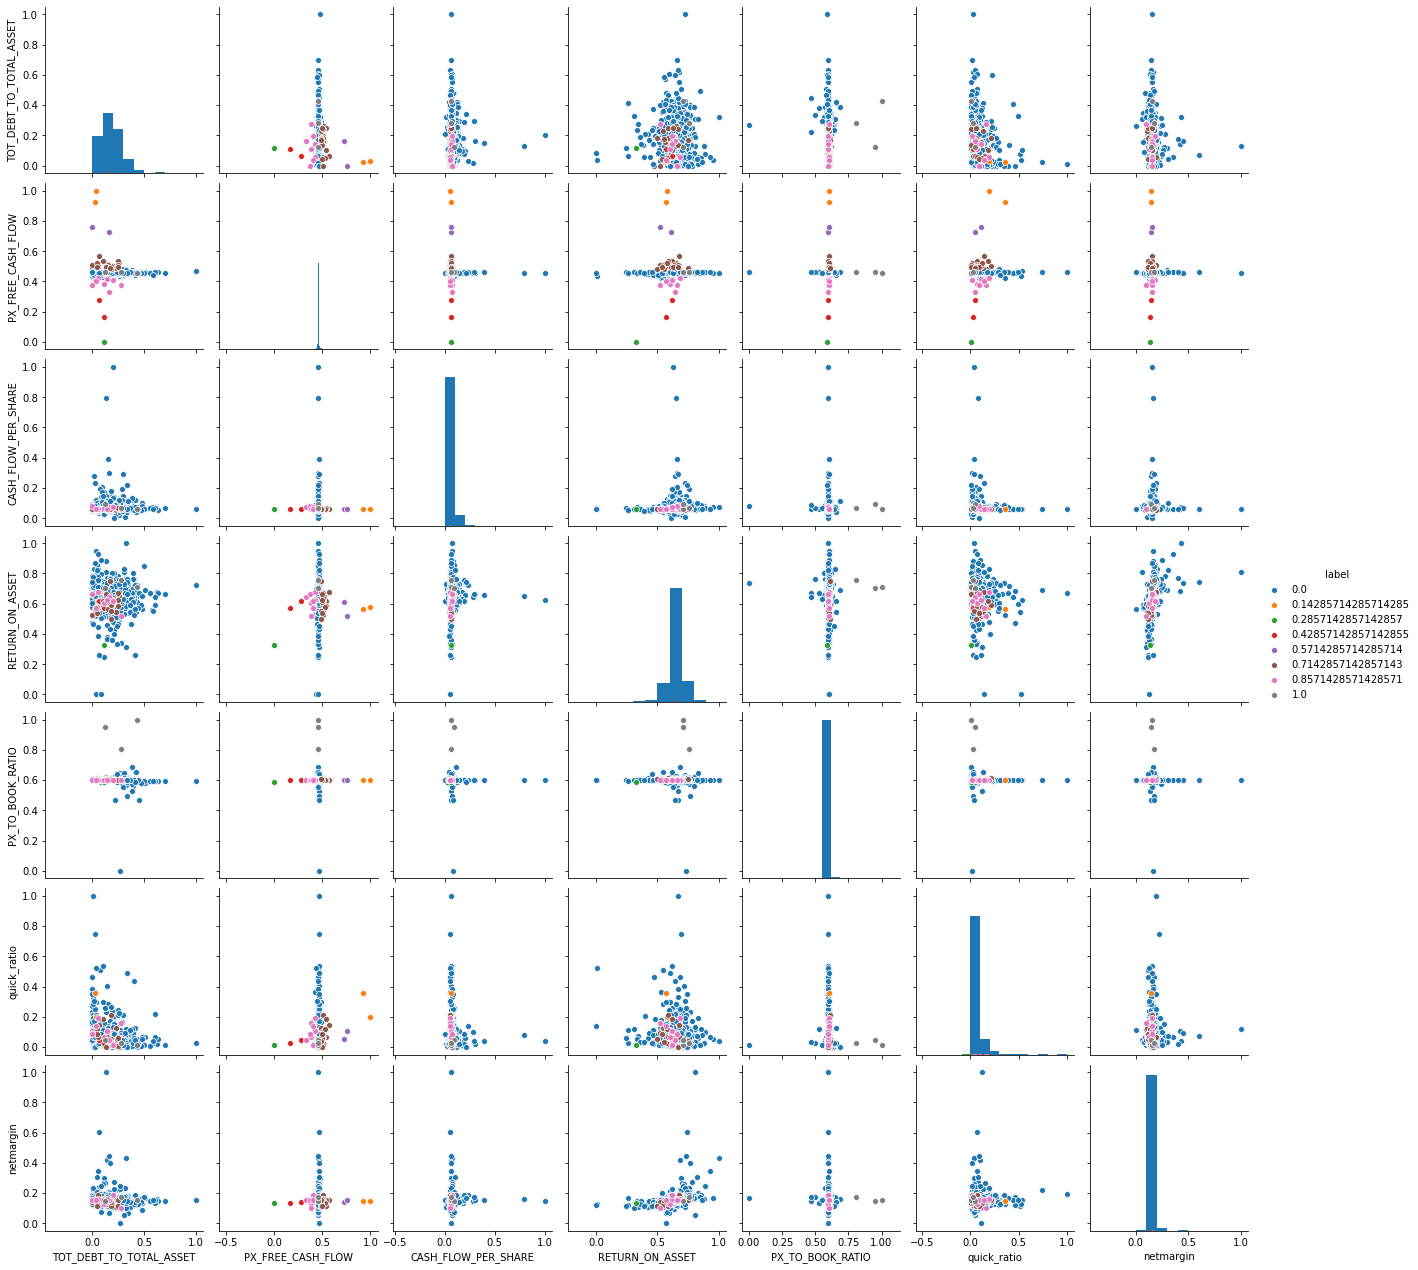

<Figure size 648x504 with 0 Axes>

In [99]:
sns.pairplot(df, hue="label", diag_kind="hist")
plt.figure(figsize=(9,7))
#very interesting.. We can actually see the clusters very distintcly at some plots.
#amazing tool for futher investigation. 
#on price per cash flow column can see distinguished clusters.


In [100]:
set(y_pred) #no repeated list = set

{0, 1, 2, 3, 4, 5, 6, 7}

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1178 entries, 65 to 40257
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TOT_DEBT_TO_TOTAL_ASSET  1178 non-null   float64
 1   PX_FREE_CASH_FLOW        1178 non-null   float64
 2   CASH_FLOW_PER_SHARE      1178 non-null   float64
 3   RETURN_ON_ASSET          1178 non-null   float64
 4   PX_TO_BOOK_RATIO         1178 non-null   float64
 5   quick_ratio              1178 non-null   float64
 6   netmargin                1178 non-null   float64
 7   label                    1178 non-null   float64
dtypes: float64(8)
memory usage: 114.8 KB


read_data

impute_na = we removed df = df.dropna()

outlier_winsorize

feature_engineering =  heatmap

normalize = zscore

scale

clustering_model

pca, visualize_clusters

performance_

randindex